In [1]:
# All imports
from Imports import *
from Preprocessing import *
from Helper import *
%matplotlib inline
warnings.filterwarnings('ignore')

In [11]:
# Load dataset and device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data paths
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALID_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_valid = pd.read_excel(VALIDATION_FILE)

if False:
    # Quantum augmented datasets using random shadows
    EXTRA_TRAIN = "../Data/32_featuresXY_train_full_ent.csv"
    EXTRA_TEST  = "../Data/32_featuresXY_test_fullent.csv"
    EXTRA_VALID = "../Data/32_featuresXY_valid_fullent.csv"
    
    # Extra features
    extra_train_df = pd.read_csv(EXTRA_TRAIN)
    extra_test_df = pd.read_csv(EXTRA_TEST)
    extra_valid_df = pd.read_csv(EXTRA_VALID)
    
    # Drop first column by index
    extra_train_df = extra_train_df.drop(extra_train_df.columns[0], axis=1)
    extra_test_df = extra_test_df.drop(extra_test_df.columns[0], axis=1)
    extra_valid_df = extra_valid_df.drop(extra_valid_df.columns[0], axis=1)
    
    # Concatenate extra features (axis=1 for columns)
    df_train = pd.concat([df_train, extra_train_df], axis=1)
    df_test  = pd.concat([df_test, extra_test_df], axis=1)
    df_valid  = pd.concat([df_valid, extra_valid_df], axis=1)
    
for i, row in df_train.head(3).iterrows():
    print(row.tolist())

print(f"✓ Training data loaded: {df_train.shape[0]} rows, {df_train.shape[1]} columns")
print(f"✓ Test data loaded: {df_test.shape[0]} rows, {df_test.shape[1]} columns")

[4207.767578125, 192.0945587158203, 294.7670288085937, 299.4913330078125, 33.25276184082031, 99651.6875, 10.141384342896378, 22.539603047233594, 1.0, 0.0, 0.4889243115484021, 0.4867517648196511, 0.4424539396315055, 0.5018124150430481, 0.4940244907570701, 0.0959180327868765, 0.4921884535578726, 0.4966290059415996, 0.3910000000000195, 0.5123237418319206, 0.5078064265353532, 0.8524242424242274, 0.4900139804273635, 0.4930194608968605, 0.5131481481481401, 0.5291524085286028, 0.510556955426182, 0.1346855327410807, 0.5011634488397192, 0.5031139373279245, 0.0151737379663572, 0.0575787569541716, 0.2653908749088174, 0.9303675320833378, 0.4890381729139292, 0.4881342718913686, 0.5599715017783495, 0.535734276400504, 0.5565928224929308, 0.5021029334082385, 0.3470295820713431, 0.4047535707272942]
[87.97427368164062, 317.01123046875, 290.7364501953125, 304.0491943359375, 20.088348388671875, 92164.1875, 0.0089225431647932, 6.829328485761937, 0.0, 0.0, 0.4148023965261842, 0.4878477258807905, 0.445589964

(256,)
torch.Size([16, 256])


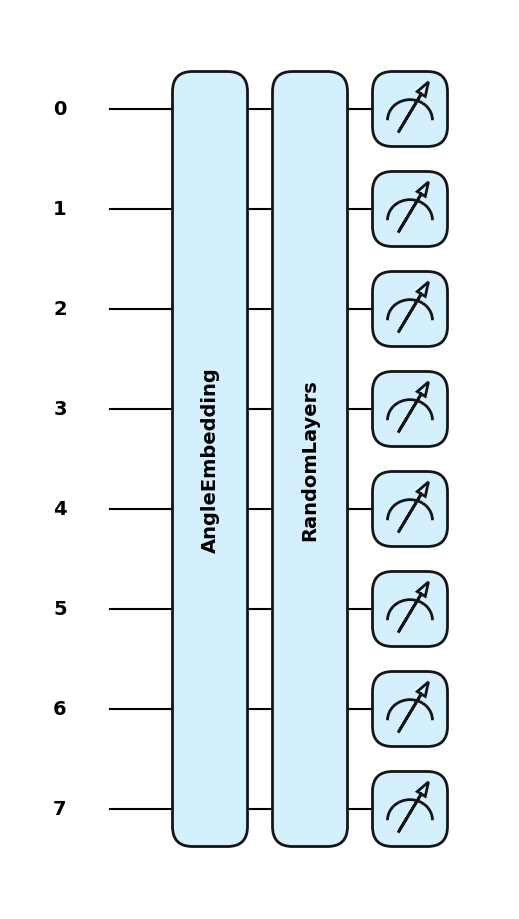

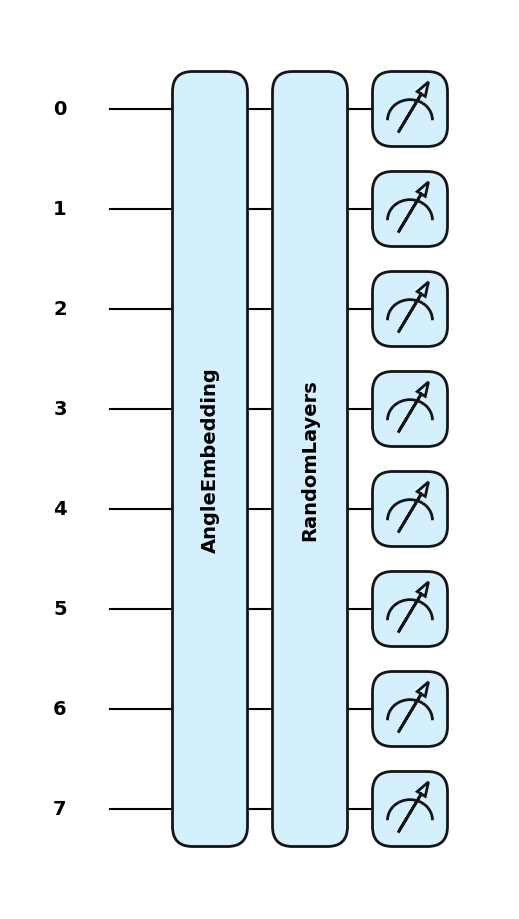

In [14]:
# Quantum circuit and helper functions
dev = qml.device("default.qubit", wires=8)
n_layers = 1

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 16))

@qml.qnode(dev)
def quantum_feature_embedding(f, phi, interface="torch", diff_method="backprop", cachesize=1000000):
    qml.AngleEmbedding(features=f, wires=range(8))

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(8)), seed = 6)

    # Measurement producing classical output values
    return qml.state()
    # return [qml.expval(qml.PauliZ(j)) for j in range(4)]

state = quantum_feature_embedding(f=[1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4], phi=rand_params)
print(state.shape)

def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    """
    Applies quantum_feature_embedding_single to a batch of inputs.

    Args:
        x_batch (torch.Tensor): (B, D) input batch.
        phi (np.ndarray or torch.Tensor): parameters for RandomLayers.
        device (str): Device to return output on.

    Returns:
        torch.Tensor: Output of shape (B, 2 ** n_qubits)
    """
    
    outputs = []
    phi = phi.to("cpu")
    for x in x_batch:
        x = x.to("cpu")
        result = quantum_feature_embedding(x, phi)
        result_tensor = result.real.to(device)
        outputs.append(result_tensor)

    return torch.stack(outputs)

sample = torch.randn(16, 8)  # Example batch
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)

output = quantum_feature_embedding_batch(sample, phi_tensor)
print(output.shape)

class quantum_feature_embedding_batch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.phi = nn.Parameter(torch.tensor(np.random.uniform(high=2 * np.pi, size=(n_layers, 3)), dtype=torch.float32))
    
    def forward(self, x_batch):
        phi = self.phi.to(device)
        outputs = []
        for x in x_batch:
            x = x.to(device)
            result = quantum_feature_embedding(x, phi)
            result_tensor = result.real.to(device)
            outputs.append(result_tensor)
    
        return torch.stack(outputs)

qml.drawer.use_style('pennylane')
fig, ax = qml.draw_mpl(quantum_feature_embedding)(f=[1/4]*8, phi=rand_params)
fig, ax = qml.draw_mpl(quantum_feature_embedding, level="device")(f=[1/4]*8, phi=rand_params)

In [15]:
# Binary DN without Quantum Layer
class BinaryDNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Encodes features from dataset
        self.feature_encoder = quantum_feature_embedding_batch

        # Classifies based on encoded features
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, features):
        feats_encoded = self.feature_encoder(features)
        class_probs = self.classifier(feats_encoded)

        return class_probs  # Shape: (batch_size, 1)

In [16]:
# Define variable and dataset
batch_size = 64
lr = 1e-2

X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'multiclass')

print(y_test[:])
print(y_train[:])
print(y_val[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

print("Batch X dtype:", X_batch.dtype)
print("Batch y dtype:", y_batch.dtype)

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(validation_data))
print("Number of test samples:", len(test_data))

0      0
1      0
2      0
3      0
4      1
      ..
195    0
196    0
197    1
198    0
199    0
Name: ef_binary, Length: 200, dtype: int64
486     0
876     1
854     1
86      0
1035    1
       ..
653     1
498     1
1106    1
180     0
1095    1
Name: ef_binary, Length: 913, dtype: int64
Batch X dtype: torch.float32
Batch y dtype: torch.float32
Number of training samples: 913
Number of validation samples: 229
Number of test samples: 200


In [6]:
# Initialize models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

scheduler_G = CosineAnnealingLR(optimizer_G, T_max=n_epochs, eta_min=1e-4)
scheduler_D = CosineAnnealingLR(optimizer_D, T_max=n_epochs, eta_min=1e-4)

g_losses = []
d_losses = []

# Tracking buffers
stats_dict = {
    'fake_dR_mean': [],
    'fake_dR_std': [],
    'fake_pixel_mean': [],
    'fake_pixel_std': [],
    'real_dR_mean': [],
    'real_dR_std': [],
    'real_pixel_mean': [],
    'real_pixel_std': []
}

dists = compute_distance_map(16,16).to(device)

In [7]:
# Plot visual of generator
# graph =  draw_graph(
#     generator,
#     input_size=(1, 9),
#     expand_nested=True,
#     depth = 1,
#     graph_name="Discriminator Architecture",
#     mode = 'train',
#     show_shapes = True,
#     hide_inner_tensors=True,   # Hides intermediate shapes
#     roll=True,                  # More compact layer grouping
#     save_graph=False,           # Set to True if you want to save
#     # node_attr={"color": "lightblue", "style": "filled"},  # Node styling
#     # edge_attr={"color": "gray"},                          # Edge styling
#     graph_dir= "TB",                         # Layout: TB (top-bottom), LR (left-right)
# )

# # Show in notebook
# graph.visual_graph

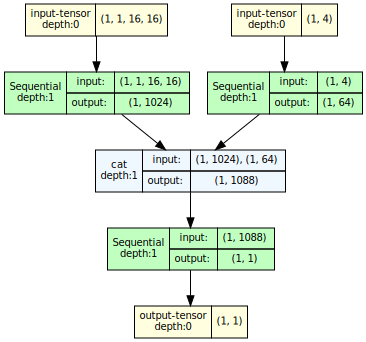

In [8]:
# Plot visual of discriminator
graph2 = draw_graph(
    discriminator,
    input_size=[(1, 1, 16, 16),(1,4)],
    expand_nested=True,
    depth = 1,
    graph_name="Discriminator Architecture",
    mode = 'train',
    show_shapes = True,
    hide_inner_tensors=True,   # Hides intermediate shapes
    roll=True,                  # More compact layer grouping
    save_graph=False,           # Set to True if you want to save
    # node_attr={"color": "lightblue", "style": "filled"},  # Node styling
    # edge_attr={"color": "gray"},                          # Edge styling
    graph_dir= "TB",                         # Layout: TB (top-bottom), LR (left-right)
)
graph2.visual_graph

In [21]:
## Load a previous model
load = True

if load:
    load_path = "models/QGAN_best_model_m21_1120.pt"  # Great sample model
    
    # Load the checkpoint
    checkpoint = torch.load(load_path)
    
    # Restore model weights
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    
    # Optionally restore tracking data
    g_losses = checkpoint["g_losses"]
    d_losses = checkpoint["d_losses"]
    
    stats_dict = checkpoint["stats_dict"]
    
    print(f"Loaded model from {load_path}")

# Show loaded model performance
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=100000)

Loaded model from models/QGAN_best_model_m21_1120.pt


[Epoch 1/100] [D loss: 0.5529] [G loss: 1.2934] [Validity_loss: 1.0418] 
 [Stat_loss: 0.1976] [NNZ_loss: 0.0540]
Sample feature coding: [0.         0.7165191  0.10202939 0.4934274  0.37997365 0.00954747
 0.03851228 0.00370328 0.04610556]


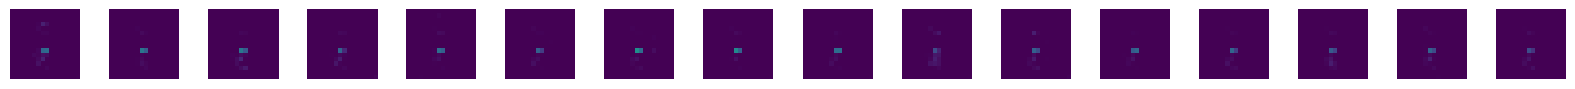

Model and statistics saved to models/class_gan_model_temp.pt
[Epoch 2/100] [D loss: 0.6161] [G loss: 1.3693] [Validity_loss: 1.1258] 
 [Stat_loss: 0.1889] [NNZ_loss: 0.0546]
Sample feature coding: [1.         1.849052   0.4212214  0.98392826 0.5839587  0.01024528
 0.04416063 0.00376572 0.03502395]


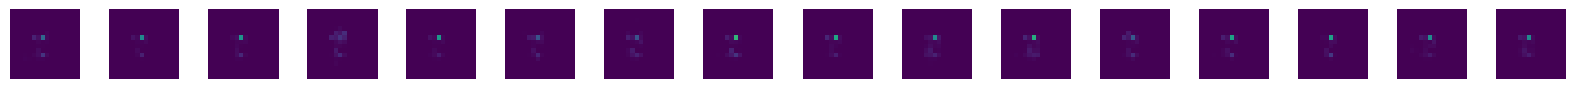

[Epoch 3/100] [D loss: 0.6247] [G loss: 0.7715] [Validity_loss: 0.5995] 
 [Stat_loss: 0.1106] [NNZ_loss: 0.0613]
Sample feature coding: [ 0.         -2.032864    0.29515126  0.50563556  0.5904243   0.00841273
  0.07700304  0.0036664   0.03960219]


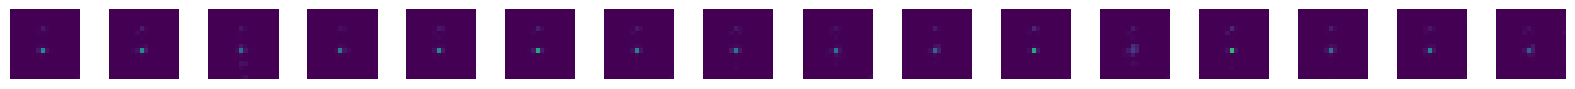

[Epoch 4/100] [D loss: 0.5277] [G loss: 1.1750] [Validity_loss: 0.9777] 
 [Stat_loss: 0.1404] [NNZ_loss: 0.0569]
Sample feature coding: [ 1.         -1.6225935   0.39257076  0.38472092  0.5382033   0.0093283
  0.0615587   0.00431329  0.01608662]


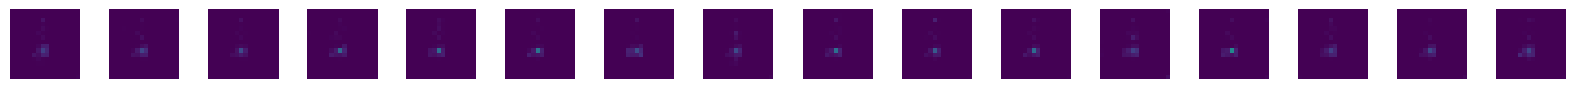

[Epoch 5/100] [D loss: 0.5070] [G loss: 1.1452] [Validity_loss: 0.9349] 
 [Stat_loss: 0.1495] [NNZ_loss: 0.0609]
Sample feature coding: [1.         0.77928    0.36399683 0.86940587 0.9120654  0.01160672
 0.06345382 0.00435379 0.03933449]


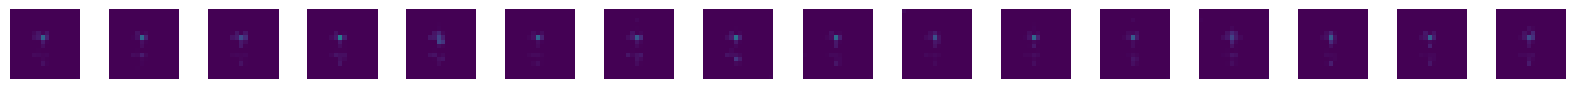

KeyboardInterrupt: 

In [14]:
# Training loop
if True:
    for epoch in range(n_epochs):
        for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
            
            # All real data are normalized in the dataloader
            real_feat = real_features.to(device)
            real_flipped_feat = flipped_features.to(device)
            real_img = real_image.unsqueeze(1).to(device)
            real_flipped_img = flipped_image.unsqueeze(1).to(device)
    
            # print(f"Real: {real_img.shape}")
    
            # Codings will be label, eta, pT, mass that get passed directly to the discriminator
            # All feature values get passed to the generator, then the output image passed to the discriminator
    
            # Discriminator training
            if i % 3 == 0:
                optimizer_D.zero_grad()
                discriminator.train()
                # Generate fake samples
                # Should be very easy to modify which values are passed as codings
                z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                      sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                      dim=1).to(device)

                # Generate the fake image
                fake_img = generator(z_codings)
                # print(f"Fake: {fake_img.shape}")
    
                # Generate eta-flipped data
                flipped_z_codings = z_codings.clone()
                flipped_z_codings[:, 1] *= -1

                fake_flipped_img = generator(flipped_z_codings)
    
                # Get predictions and labels
                real_disc_codings = real_feat[:,:num]
                real_flipped_disc_codings = real_flipped_feat[:,:num]
                fake_disc_codings = z_codings[:,:num]
                fake_flipped_disc_codings = flipped_z_codings[:,:num]

                # Discriminator gets codings + image
                real_pred = discriminator(real_img, real_disc_codings)
                real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
                fake_pred = discriminator(fake_img, fake_disc_codings)
                fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)
    
                preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)

                # Labels
                ones = torch.ones(2*len(fake_pred))
                zeros = torch.zeros(2*len(real_pred))
                labels = (torch.cat([ones, zeros], dim=0)).to(device)
    
                # Discriminator loss is just its ability to distinguish
                d_loss = torch.nn.BCELoss()(preds, labels)
    
                d_loss.backward()
                optimizer_D.step()
    
            # Generator Training
            if i % 1 == 0:
                optimizer_G.zero_grad()
                generator.train()
                
                # Generate fake data
                # Should be very easy to modify which values are passed as codings
                z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                      sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                      dim=1).to(device)
    
                # Generate image
                fake_img = generator(z_codings)
    
                # Generate eta-flipped data
                flipped_z_codings = z_codings.clone()
                flipped_z_codings[:, 1] *= -1

                fake_flipped_img = generator(flipped_z_codings)

                ## BCE Discriminator Loss
                # Discriminator gets codings + generated image
                fake_disc_codings = z_codings[:,:num]
                fake_flipped_disc_codings = flipped_z_codings[:,:num]

                # Get predictions and labels
                fake_pred = discriminator(fake_img, fake_disc_codings)
                fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

                target = torch.ones_like(fake_pred)
                bce = nn.BCELoss()
                validity_loss = bce(fake_pred, target) + bce(fake_flipped_pred, target)
    
                ## Stat loss
                # Compute statistics for original and flipped fake images
                fake_stats_orig = compute_fake_statistics(fake_img.to('cpu'), dists.to('cpu'))
                fake_stats_flip = compute_fake_statistics(fake_flipped_img.to('cpu'), dists.to('cpu'))
                
                # Average the statistics
                fake_stats = {
                    'fake_dR_mean': 0.5 * (fake_stats_orig['fake_dR_mean'] + fake_stats_flip['fake_dR_mean']),
                    'fake_dR_std': 0.5 * (fake_stats_orig['fake_dR_std'] + fake_stats_flip['fake_dR_std']),
                    'fake_pixel_mean': 0.5 * (fake_stats_orig['fake_pixel_mean'] + fake_stats_flip['fake_pixel_mean']),
                    'fake_pixel_std': 0.5 * (fake_stats_orig['fake_pixel_std'] + fake_stats_flip['fake_pixel_std']),
                }
                
                # Move to device
                fake_dR_mean = fake_stats['fake_dR_mean'].to(device)
                fake_dR_std = fake_stats['fake_dR_std'].to(device)
                fake_pixel_mean = fake_stats['fake_pixel_mean'].to(device)
                fake_pixel_std = fake_stats['fake_pixel_std'].to(device)
                
                # Get real stats from z_codings (features 5–8)
                real_dR_mean = z_codings[:,5]
                real_dR_std = z_codings[:,6]
                real_pixel_mean = z_codings[:,7]
                real_pixel_std = z_codings[:,8]
                
                real_stats = {
                    'real_dR_mean': real_dR_mean,
                    'real_dR_std': real_dR_std,
                    'real_pixel_mean': real_pixel_mean,
                    'real_pixel_std': real_pixel_std
                }
                
                # stats_dict = track_statistics(fake_stats, real_stats)
                # plot_tracked_statistics(stats_dict)
                
                if n_epochs - epoch <= 10:
                    # Track the last statistics
                    stats_dict = track_statistics(fake_stats, real_stats)
                    plot_tracked_statistics(stats_dict)
                
                # Statistical KL Divergence loss
                kl_total = 0
                kl1 = kde_kl_divergence_torch(real_dR_mean / batch_size, fake_dR_mean) / 0.000003
                # print(f"KL(real_dR_mean, fake_dR_mean) = {kl1.item()}")
                
                kl2 = kde_kl_divergence_torch(real_dR_std / batch_size, fake_dR_std) / 0.003
                # print(f"KL(real_dR_std, fake_dR_std) = {kl2.item()}")
                
                kl3 = kde_kl_divergence_torch(real_pixel_mean / batch_size, fake_pixel_mean) / 0.00000007
                # print(f"KL(real_pixel_mean, fake_pixel_mean) = {kl3.item()}")
                
                kl4 = kde_kl_divergence_torch(real_pixel_std / batch_size, fake_pixel_std) / 0.0005
                # print(f"KL(real_pixel_std, fake_pixel_std) = {kl4.item()}")
                
                kl_total = kl1 + kl2 + kl3 + kl4
    
                stat_loss = kl_total

                # Number non-zero loss
                fake_nnz = soft_count_nonzero(fake_img, threshold=3e-3, sharpness=10000.0)
                real_nnz = soft_count_nonzero(real_img, threshold=3e-3, sharpness=10000.0)
                nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)
    
                
                # Total generator loss is the average of the discriminator's predictions of the original and flipped data
                # + number of non-zero pixels loss
                # + the difference between input and output dR and pixel statistics
    
                alpha = .4
                beta = .001
                chi = .03
    
                g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss)

                g_loss.backward()
                optimizer_G.step()
    
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[-1]:.4f}] [G loss: {g_losses[-1]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

        plot_generated_samples(generator, dataset, kdes, batch_size=16, latent_dim=256)

        if epoch % 10 == 0:
            # Save model states and tracked data in a temp file during training
            save_path = f"models/class_gan_model_temp.pt"
            torch.save({
                "generator_state_dict": generator.state_dict(),
                "discriminator_state_dict": discriminator.state_dict(),
                "g_losses": g_losses,
                "d_losses": d_losses,
                "stats_dict": stats_dict
            }, save_path)

            print(f"Model and statistics saved to {save_path}")

In [15]:
## Save Model
# Create output directory if it doesn't exist
save = True

if save:
    os.makedirs("models", exist_ok=True)
    
    # Timestamp for unique filenames
    timestamp = datetime.now().strftime("%m%d_%H%M")
    
    # Save model states and tracked data in a single file
    save_path = f"models/QGAN_best_model_{timestamp}.pt"
    torch.save({
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "g_losses": g_losses,
        "d_losses": d_losses,
        "stats_dict": stats_dict
    }, save_path)
    
    print(f"Model and statistics saved to {save_path}")

Model and statistics saved to models/QGAN_best_model_0724_1317.pt


![image.png](attachment:7aee3b98-579c-4bcb-9682-eb417b7e3a7a.png)

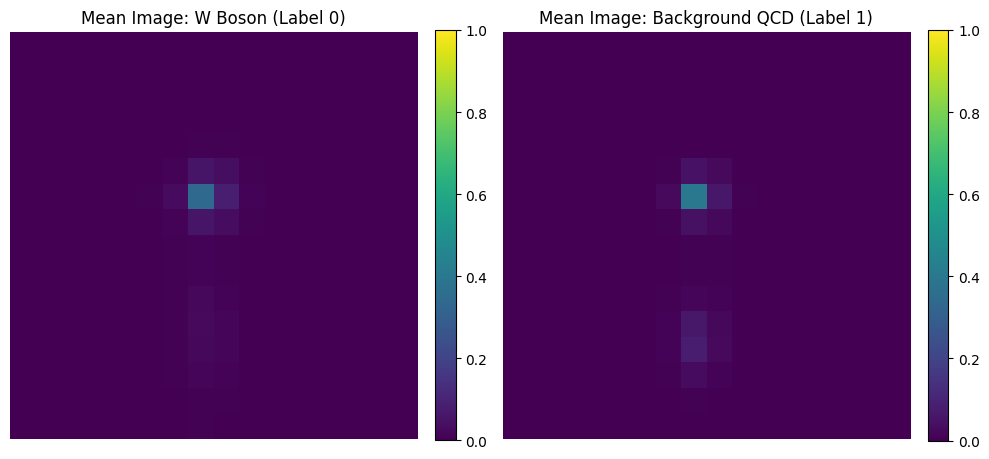

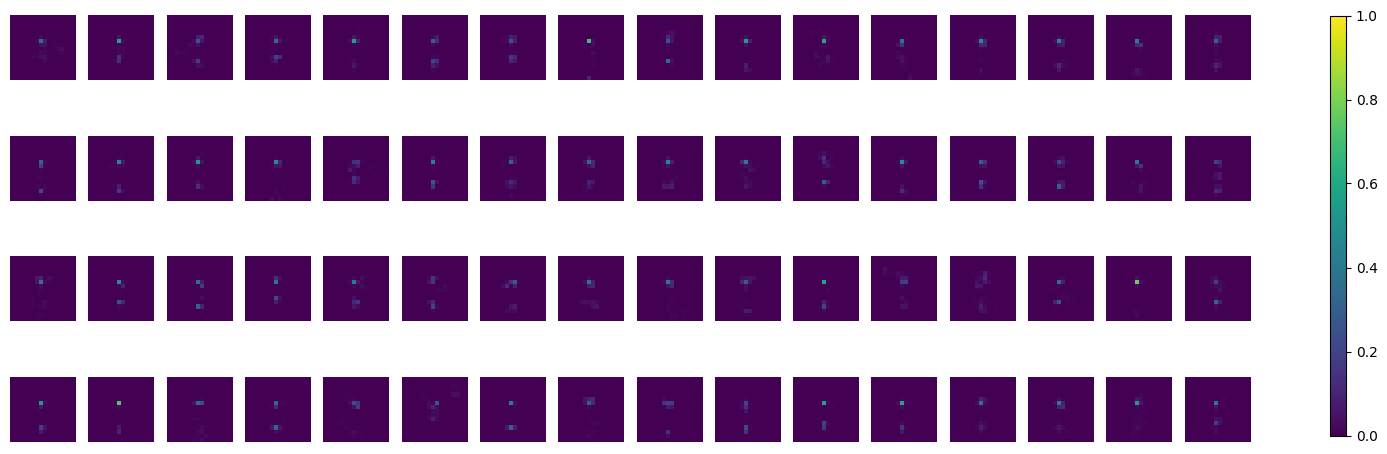

In [16]:
plot_real_samples(dataset)

In [ ]:
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=100000)

# Optional args:
#     generator,
#     discriminator,
#     dataset,
#     kdes,
#     batch_size=16,
#     latent_dim=256,
#     codings=None,
#     plot_distributions=True,
#     compare_discriminator=True

plot_metrics(g_losses, d_losses)